In [ ]:
#Install spacy by running following code from anaconda command prompt 
# conda install -c conda-forge spacy
# python -m spacy download en_core_web_sm

In [ ]:
# using this version of gensim because latest version (4.0) removes support for wrappers
!pip install gensim==3.8.3 


In [1]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
import matplotlib.pyplot as plt
%matplotlib inline

# NLTK Stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['us', 're'])

# load spacy
import en_core_web_sm
nlp = en_core_web_sm.load()

#wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\mhatres\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Import input data file and clean up response text
df = pd.read_excel (r'C:\Users\mhatres\Documents\RedGateDemos\TeamHealthRawDataForDemo_FromGithubRepo.xlsx')
print (df.head(10))

df2 = df[['Response']]
#print (df2.head(10)) 

# convert to string 
df3 = df2['Response'].apply(str)

#covert to lower-case
df4 = df3.str.casefold()

#remove all non-aphabet characters
df5 = df4.str.replace("[^a-zA-Z#]", " ")

print (df5.head(10)) 

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


    Period Manager    Team                                           Response  \
0  2019-Q1   Mgr 1  Team 1  We're a fun team that works well together and ...   
1  2019-Q1   Mgr 1  Team 1  we have a sound and collaborative team focused...   
2  2019-Q1   Mgr 1  Team 1  we work well as a team, we have fun together, ...   
3  2019-Q1   Mgr 1  Team 1  I fell pretty good about the health of our tea...   
4  2019-Q1   Mgr 1  Team 1  happy with team's overall health and good dyna...   
5  2019-Q1   Mgr 1  Team 1                                              Solid   
6  2019-Q1   Mgr 1  Team 1  The Team 2 team is a  collaborative group prod...   
7  2019-Q1   Mgr 1  Team 1  We have great teamwork.  We have a lot of fun....   
8  2019-Q1   Mgr 1  Team 1  We feel good about our teamwork, process, tech...   
9  2019-Q1   Mgr 1  Team 2  A blast!  Always working towards delivering mo...   

   Unnamed: 4  Unnamed: 5  Unnamed: 6  Unnamed: 7  Unnamed: 8  Unnamed: 9  \
0         NaN         NaN      

<ipython-input-2-3eb5c1c964ba>:15: FutureWarning: The default value of regex will change from True to False in a future version.
  df5 = df4.str.replace("[^a-zA-Z#]", " ")


C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


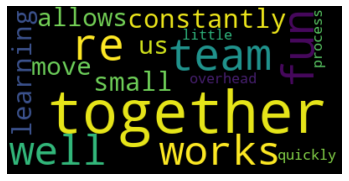

In [3]:
# Create and generate a word cloud image:

text = df5[0]
wordcloud = WordCloud().generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [4]:
# Convert dataframe to list and tokenize words
data = df5.values.tolist()
 
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence)))  

data_words = list(sent_to_words(data))

# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=3, threshold=10) 
trigram = gensim.models.Phrases(bigram[data_words], threshold=8)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# print a sample 
print(trigram_mod[bigram_mod[data_words[3]]])


['fell', 'pretty_good', 'about', 'the', 'health', 'of', 'our', 'team', 'my', 'main', 'concerns', 're', 'lack_of', 'vision', 'into', 'what', 'our', 'application', 'true', 'purpose', 'is', 'and', 'the', 'future', 'direction', 'of', 'our', 'team']


C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
# Define functions for stopwords, n-grams and lemmatization

def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
# call the functions created above

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['fun', 'team', 'together', 'constantly', 'learn', 'together', 'small', 'allow', 'move', 'quickly', 'process', 'little', 'overhead']]


In [7]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# view corpus in human readable format
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[1:2]]

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('process', 1),
  ('team', 1),
  ('accordingly', 1),
  ('adapt', 1),
  ('business', 1),
  ('capability', 1),
  ('collaborative', 1),
  ('current', 1),
  ('delivery', 1),
  ('discipline', 1),
  ('ensure', 1),
  ('evolve', 1),
  ('expand', 1),
  ('focus', 1),
  ('opportunity', 1),
  ('product', 2),
  ('proper', 1),
  ('scope', 2),
  ('sound', 1),
  ('value', 1),
  ('vision', 2)]]

In [8]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, # change this number and re-run as needed
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)


# Print the Keyword in the topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.038*"team" + 0.025*"good" + 0.022*"improvement" + 0.018*"overall" + '
  '0.018*"feel" + 0.014*"need" + 0.014*"improve" + 0.013*"health" + '
  '0.011*"positive" + 0.010*"green"'),
 (1,
  '0.100*"team" + 0.037*"work" + 0.032*"good" + 0.026*"great" + 0.020*"feel" + '
  '0.014*"support" + 0.013*"overall" + 0.010*"well" + 0.009*"fun" + '
  '0.009*"lot"')]


In [9]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 
# value closer to 0 is better

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)
# value closer to 1 is better

# change value of num_topics and re-run, you should notice these scores change

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.089494478111165

Coherence Score:  0.22104142033971352


In [10]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

# change num_topics and re-run until intertopic distance chart looks good

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x    y  topics  cluster      Freq
topic                                          
1      0.097859  0.0       1        1  58.24415
0     -0.097859  0.0       2        1  41.75585, topic_info=            Term        Freq       Total Category  logprob  loglift
33          work   73.000000   73.000000  Default  30.0000  30.0000
114  improvement   31.000000   31.000000  Default  29.0000  29.0000
71         great   52.000000   52.000000  Default  28.0000  28.0000
39        health   18.000000   18.000000  Default  27.0000  27.0000
10          team  246.000000  246.000000  Default  26.0000  26.0000
..           ...         ...         ...      ...      ...      ...
7        process    9.594941   17.651127   Topic2  -4.9735   0.2638
101          lot   11.466647   28.392894   Topic2  -4.7952  -0.0334
180        trend    7.471725   11.212938   Topic2  -5.2236   0.4674
69          well    9.538293   29.643175   Topic2  -4.9794  -0.2606
32         think    7.936523   24.528794   Topic2  -5.1632  -0.2550

[128 rows x 6 columns], token_table=      Topic      Freq    Term
term                         
70        1  0.086976   agile
70        2  0.869758   agile
286       1  0.975693   ahead
91        1  0.976848  always
91        2  0.065123  always
...     ...       ...     ...
33        2  0.013690    work
210       1  0.094918   would
210       2  0.949179   would
244       1  0.105064  yellow
244       2  0.945578  yellow

[143 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 1])

In [11]:
# Retrain LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, # change this number and re-run as needed
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Regenerate model performance metrics
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Recereate topic visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.174804552909445

Coherence Score:  0.245479070649285


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.002090 -0.116565       1        1  43.337619
1     -0.120114  0.056748       2        1  36.885054
0      0.118024  0.059817       3        1  19.777327, topic_info=            Term       Freq      Total Category  logprob  loglift
87          need  35.000000  35.000000  Default  30.0000  30.0000
33          work  72.000000  72.000000  Default  29.0000  29.0000
83       improve  27.000000  27.000000  Default  28.0000  28.0000
114  improvement  31.000000  31.000000  Default  27.0000  27.0000
71         great  51.000000  51.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
101          lot   5.632992  28.199070   Topic3  -4.7587   0.0100
316          see   4.355753  14.334526   Topic3  -5.0159   0.4295
136        thing   4.191725  20.110461   Topic3  -5.0543   0.0525
71         great   4.478405  51.442628   Topic3  -4.9881  -0.8206
189    challenge   3.211610   7.012372   Topic3  -5.3206   0.8397

[186 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
393       2  0.936953     achieve
13        1  0.838980       adapt
351       1  0.978801         add
70        1  0.958504       agile
286       2  0.985785       ahead
...     ...       ...         ...
112       2  0.874589     willing
33        1  0.397286        work
33        2  0.602779        work
125       2  0.869798  works_well
210       3  0.934751       would

[216 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 1])

In [12]:
# Retrain LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, # change this number and re-run as needed
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

# Regenerate model performance metrics
print('\nPerplexity: ', lda_model.log_perplexity(corpus)) 

coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

# Recereate topic visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, id2word)
vis

C:\Users\mhatres\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)



Perplexity:  -6.253643478957044

Coherence Score:  0.2746278209316812


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.043299 -0.101630       1        1  32.669743
2     -0.063303 -0.054942       2        1  28.008187
1     -0.079927  0.139174       3        1  25.697507
0      0.186529  0.017399       4        1  13.624563, topic_info=            Term       Freq      Total Category  logprob  loglift
33          work  72.000000  72.000000  Default  30.0000  30.0000
91        always  15.000000  15.000000  Default  29.0000  29.0000
67       support  32.000000  32.000000  Default  28.0000  28.0000
48       overall  52.000000  52.000000  Default  27.0000  27.0000
114  improvement  31.000000  31.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
136        thing   3.453520  19.932862   Topic4  -4.8753   0.2403
32         think   3.157821  24.577432   Topic4  -4.9648  -0.0587
7        process   3.004541  17.593095   Topic4  -5.0146   0.2259
249         area   3.083620  24.872270   Topic4  -4.9886  -0.0944
39        health   2.815691  19.163281   Topic4  -5.0795   0.0755

[248 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
393       3  0.935902     achieve
13        1  0.840746       adapt
351       2  0.754071         add
418       1  0.735478     address
418       3  0.147096     address
...     ...       ...         ...
210       1  0.395911       would
210       4  0.593866       would
346       4  0.789355  would_like
244       1  0.622078      yellow
244       4  0.311039      yellow

[287 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])